In [1]:
# %load ../../scripts/qc.py
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import argparse
from scipy.stats import linregress
from collections import defaultdict

In [2]:
######### Input ########

## Read in data; use the ID to index individual oligos


# args = argparse.ArgumentParser()
# args.add_argument('-input', type=str, default='../data/2017-09-28/annotatedCounts.xlsx',
#                     help='Path to input counts excel sheet')
# args.add_argument('-out_path', type=str, default='../data/2017-09-28/')
# args.add_argument('-samples', type=str, default='../data/2017-09-28/samples.tsv')
# args = args.parse_args()

# counts = pd.read_excel(args.input, index_col=0)
counts = pd.read_csv('./2017.07.05.annotatedCounts.csv', index_col=0)

out_path = './'

In [4]:
#########  Initial cleanup & normalization #########

# For convenience, separate out the metadata, input counts, background counts and metadata.
def proportions(df):
    ''' For each column, divide each element by the sum of the column (column sums to 1)'''
    xsum=df.sum(0)
    df = df.div(xsum, axis='columns')
    return df

input_cols = [ c for c in counts.columns.values if 'input' in c.lower() ]
beads_cols = [ c for c in counts.columns.values if 'beads' in c.lower() ]
metadata_cols = ['Virus_Strain', 'Start_to_End_nt', 'Peptide_sequence']
sample_cols = [c for c in counts if not any([c in input_cols, c in beads_cols, c in metadata_cols])]

metadata = counts[metadata_cols]
# Standardize each column to sum to 1
values = proportions(counts[[c for c in counts.columns.values if c not in metadata_cols]])
input_ctrls = proportions(values[input_cols])
beads_ctrls = proportions(values[beads_cols])

/Users/Sidney/Library/Python/2.7/lib/python/site-packages/pandas/core/frame.py:2754: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


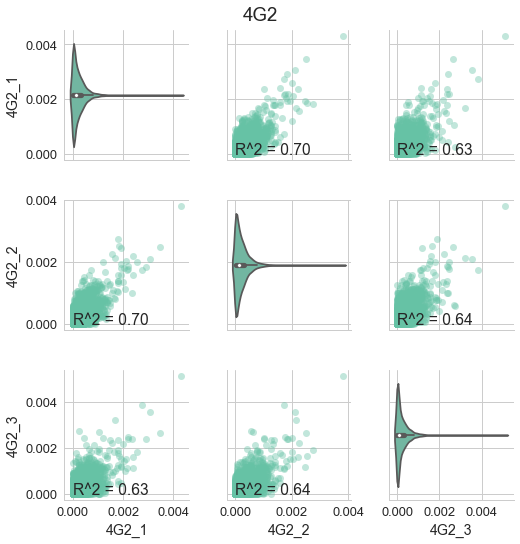

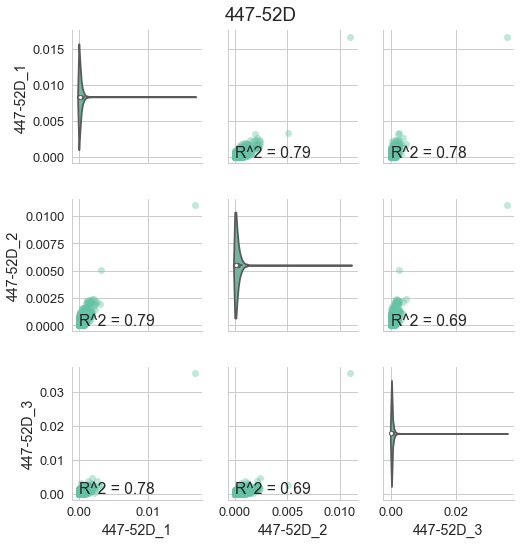

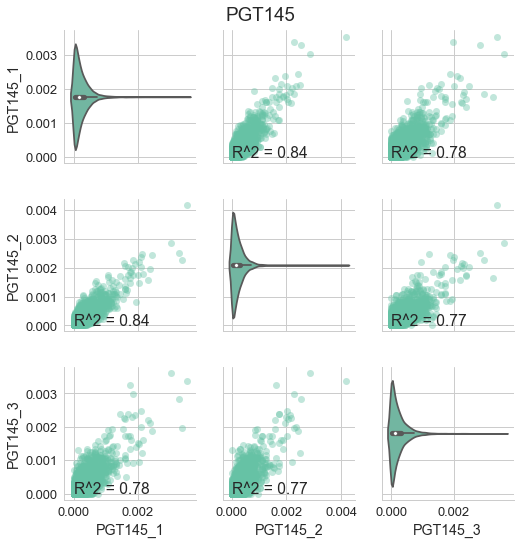

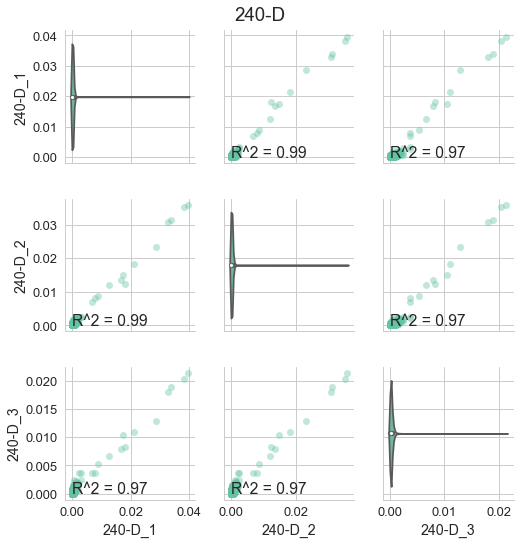

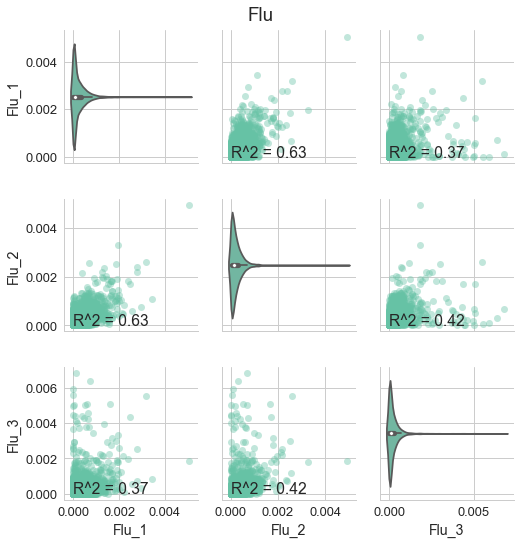

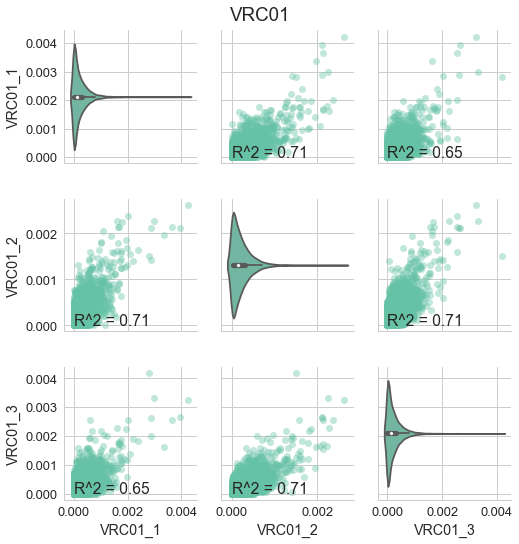

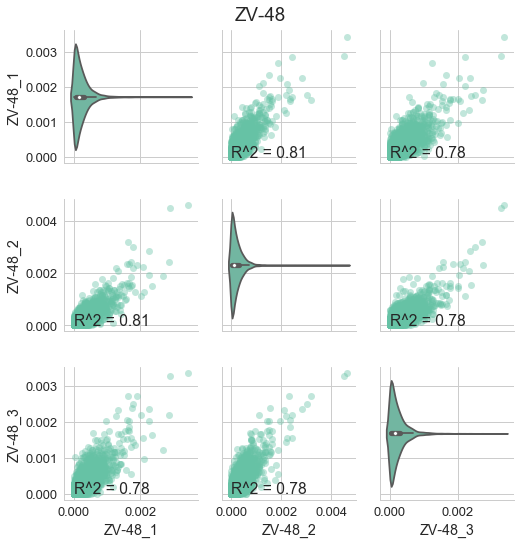

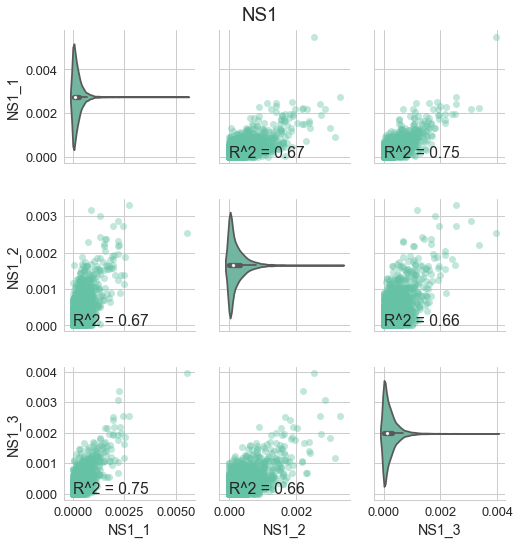

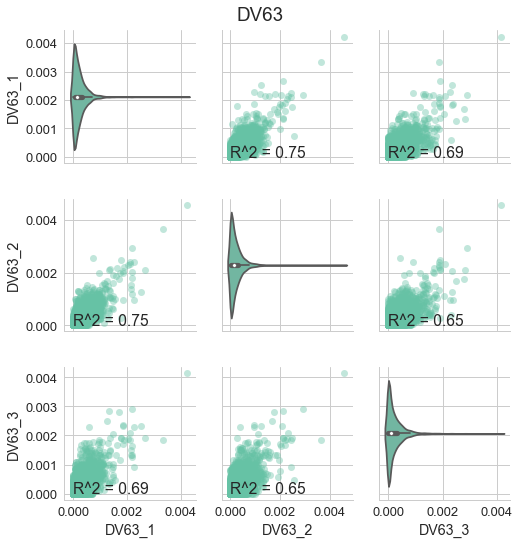

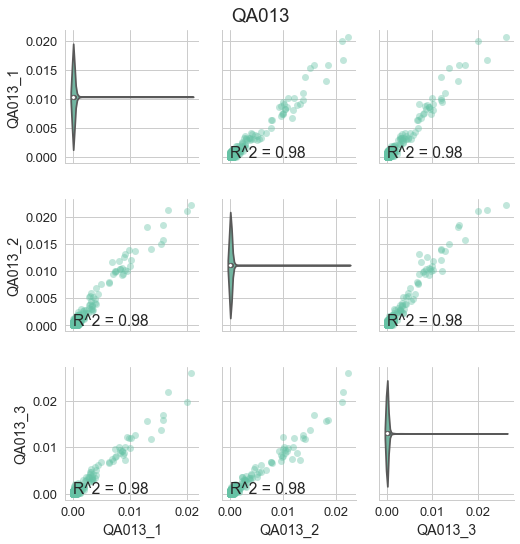

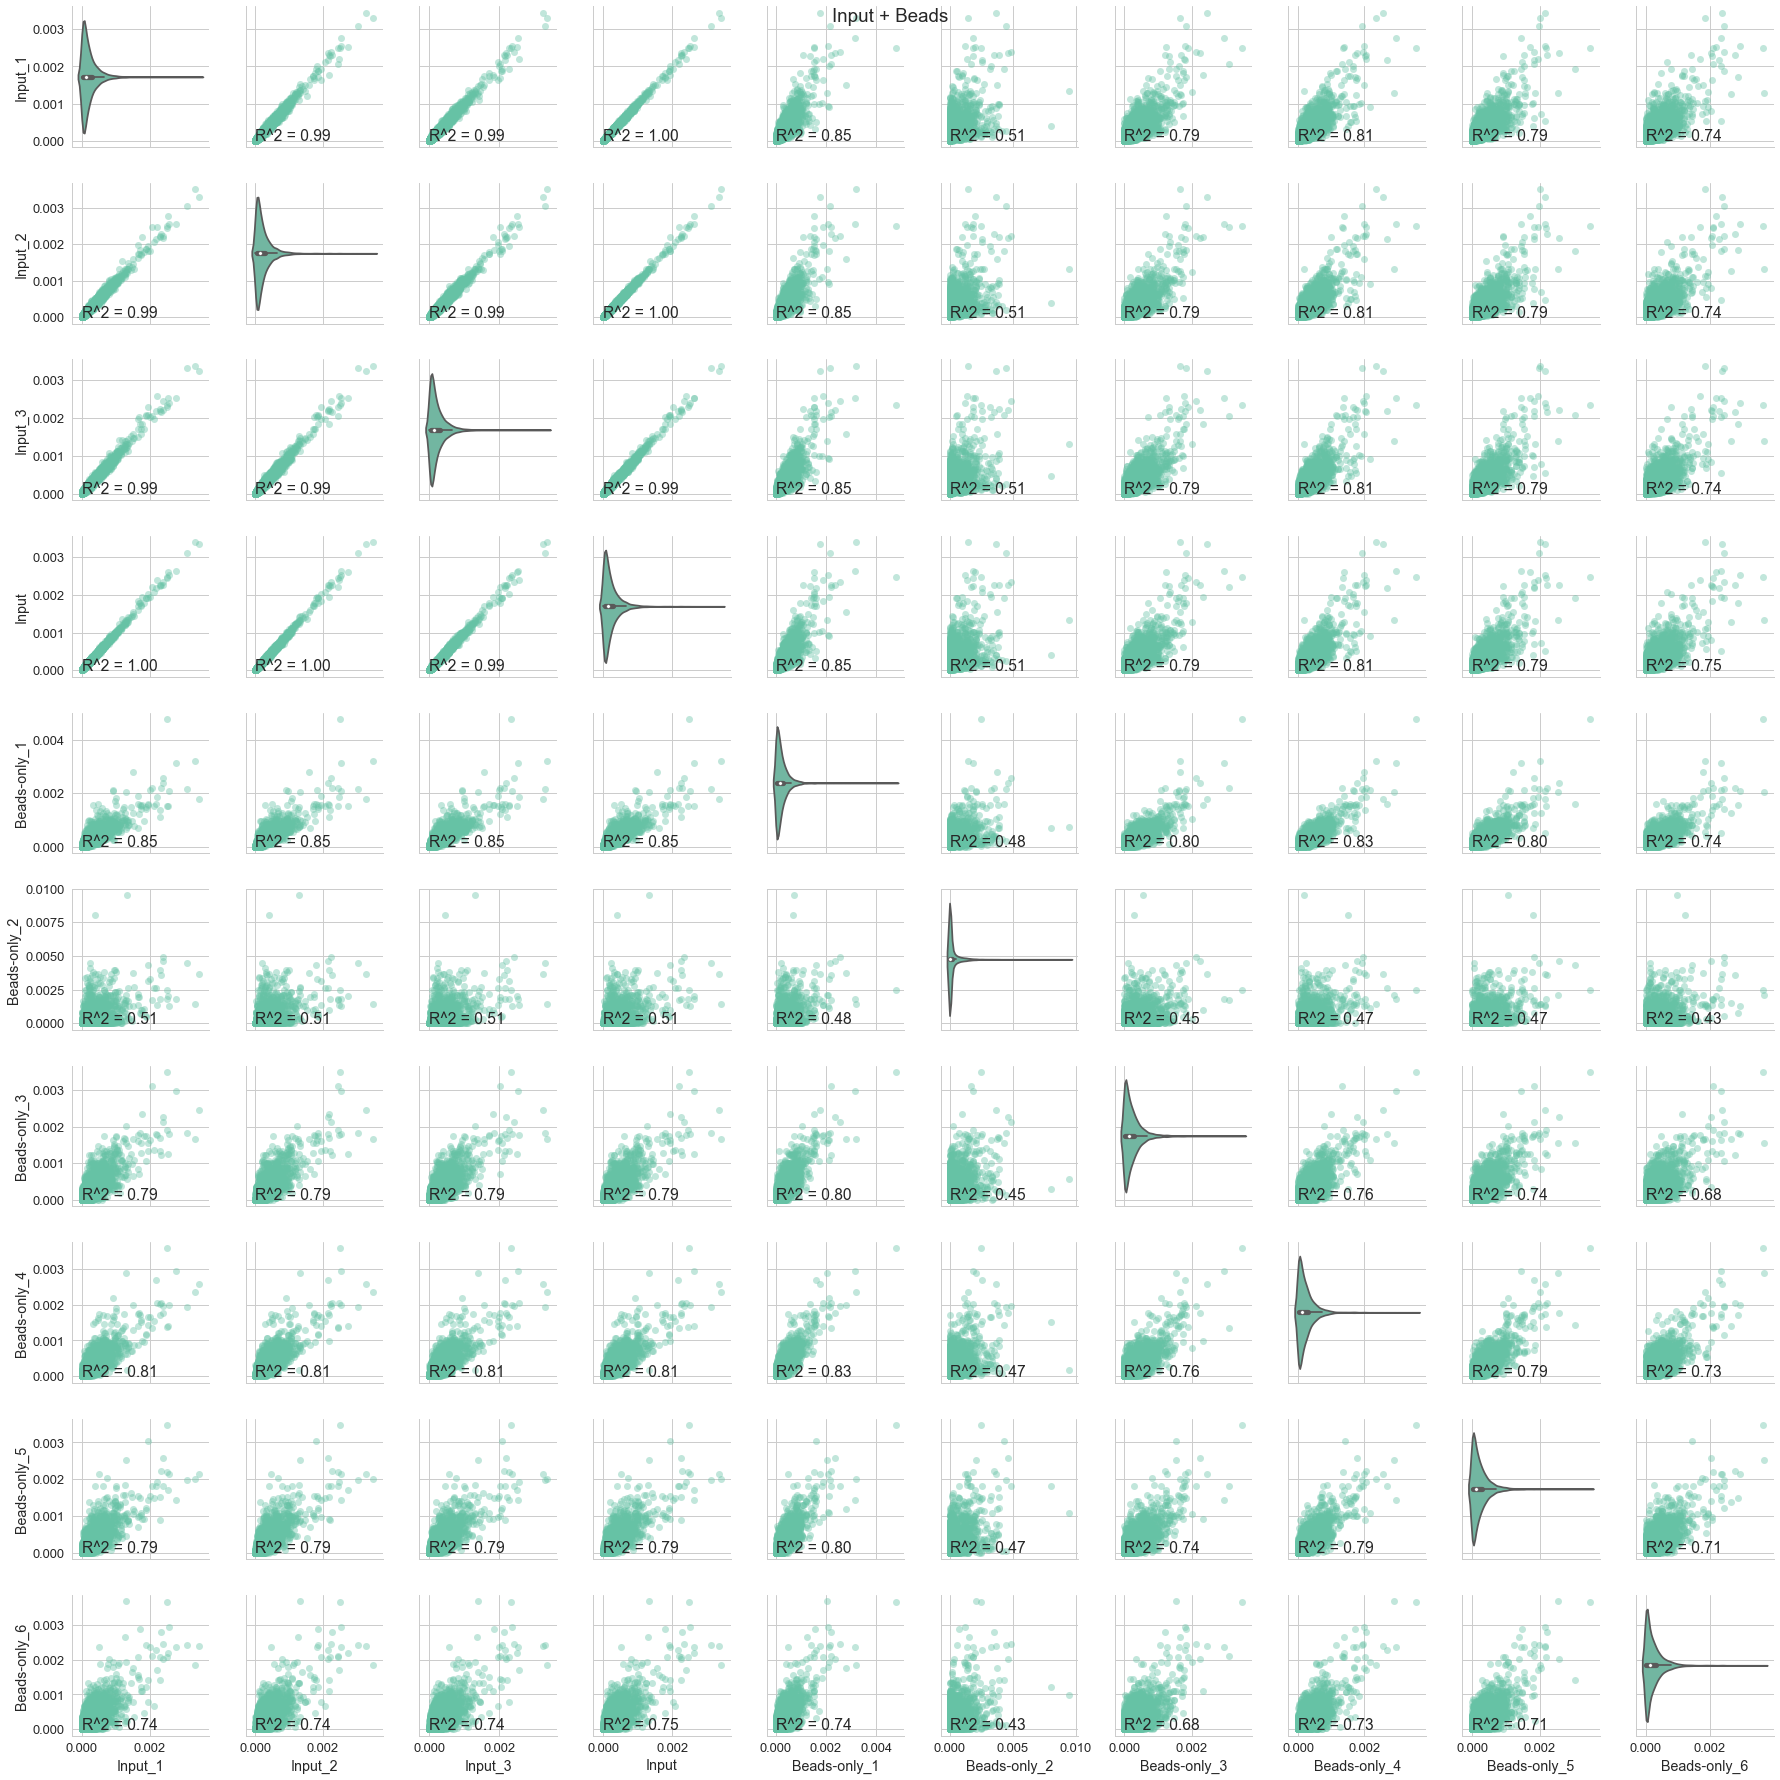

In [6]:
######  Find technical and biological replicates, plot direct comparisons #########
# sample_sera_map = { i.split()[0]: i.split()[1] for i in open(args.samples, 'r').readlines() }
# biological_replicates = defaultdict(list)
# for sample, sera in sample_sera_map.items():
#     all_sample_reps = [c for c in sample_cols if sample.upper() in c.upper()]
#     biological_replicates[sera] += all_sample_reps
# biological_replicates = dict(biological_replicates)

technical_replicates = defaultdict(list)
for serum in sample_cols:
    technical_replicates[serum.rsplit('_', 1)[0]].append(serum) # Find replicates
technical_replicates = dict(technical_replicates) # Turn off defaultdict behavior

sns.set(style='whitegrid', font_scale = 1.3, palette='Set2') ## Make all of our plots prettier
def compare_replicates(df, columns, title, fname):
    ''' Plot sanity checks for technical replicates '''
    if columns:
        if len(columns) == 1:
            return
        replicates = df[columns]
        replicates.fillna(0, inplace=True)
    else:
        replicates = df

    def plot_comparison(x,y, **kwargs):
        scatter = plt.plot(x,y, 'o', alpha=0.4)
        try:
            r_2 = linregress(x,y)[2]
            scatter[0].axes.text(0,0, 'R^2 = %.2f'%(r_2))
        except:
            pass
        return scatter

    g = sns.PairGrid(replicates, diag_sharey=False)
    g.map_diag(sns.violinplot)
    g.map_offdiag(plot_comparison, )

    g.fig.suptitle(title, va='bottom')
    plt.tight_layout()
    plt.show()
#     plt.savefig(out_path+'/figs/'+fname, bbox_inches='tight')
    plt.close()

for serum, tech_reps in technical_replicates.items():
    compare_replicates(values, tech_reps, serum, serum+'_tech_reps.png')

# for serum, bio_reps in biological_replicates.items():
#     compare_replicates(values, bio_reps, serum, serum+'_bio_reps.png')

compare_replicates(values, input_cols + beads_cols, 'Input + Beads', 'ctrl_reps.png')

In [7]:
## Drop any individaul replicates with R^2 < 0.7 or so; drop entire samples if all three replicates disagree
drop = ['4G2_1', '4G2_2', '4G2_3', 'Flu_1', 'Flu_2', 'Flu_3', 'NS1_2', 'DV63_2', 'Beads-only_2']

## Write to file for reference later
with open('./drop.tsv', 'w') as f:
    for sample in drop:
        f.write(sample+'\n')
f.close()

In [8]:
#######  Tidy up the metadata a bit  ########
metadata = counts[metadata_cols]

# Tidy start and end coordinates --> integers
metadata['start'], metadata['end'] = metadata['Start_to_End_nt'].str.split('to', 1).str
metadata['start'] = metadata['start'].map(lambda x: int(x))
metadata['end'] = metadata['end'].map(lambda x: int(x.split('.')[0])) ## TODO
metadata.drop('Start_to_End_nt', inplace=True, axis=1)

# Tidy up virus and strain names
def parse_strains(virusstrain):
    if 'HIV' in virusstrain:
        # e.g., 'HIV_Env_QB850.72p.C14_A1.HIV_Env_QB850.632p.B10' --> 'HIV_Env', ['QB85072pC14A1', 'QB850632pB10']
        gene = virusstrain.split('HIV_', 1)[1].split('_', 1)[0] # Env
        virus = 'HIV'+'_'+gene.upper() # HIV_ENV
        strains = virusstrain.split('HIV_%s_'%gene) # ['QB850.72p.C14_A1.', 'QB850.632p.B10']
        strains = [ s.replace('.', '').replace('_', '').replace('-', '').upper() for s in strains if s != '']
        # ['QB85072PC14A1', 'QB850632PB10']
    
    else:
        # e.g., 'DENV3_BR-BID-V2403-2008.DENV3_Mozambique1985'
        # The ONNV sequences overlap with the CHIKV sequences; for now, we'll omit it; this should be revisited. TODO
        names = [s for s in virusstrain.split('.') if 'ONNV' not in s] # ['DENV3_BR-BID-V2403-2008', 'DENV3_Mozambique1985']
        virus = [s.split('_', 1)[0] for s in names] # ['DENV3']
        
        if len(set(virus)) != 1:
            virus, strains = np.nan, np.nan
        else:
            virus = virus[0] # 'DENV3'
            strains = [s.split(virus+'_', 1)[1].replace('-', '').replace('_', '').upper() for s in names if s != '']
            # ['BRBIDV24032008', 'MOZAMBIQUE1985']

    return pd.Series({'virus': virus, 'strains':strains})

new_names = [parse_strains(v) for v in metadata['Virus_Strain']]
metadata['virus'] = [n['virus'] for n in new_names]
metadata['strains'] = [n['strains'] for n in new_names]
metadata.rename(columns={'Peptide_sequence':'sequence'}, inplace=True)
metadata.drop('Virus_Strain', axis=1, inplace=True)
metadata.dropna(how='any', inplace=True, axis=(0, 1))

def adjust_hiv(row):
    HIV_map = {
    'HIV_GAG': 790,
    'HIV_POL': 2085,
    'HIV_ENV': 6225,
    'HIV_REV': 5970,
    'HIV_NEF': 8797,
    'HIV_VPU': 6062,
    'HIV_VPR': 5559,
    'HIV_VIF': 5041, 
    'HIV_TAT': 5831}

    if 'HIV' in row['virus']:    
        row['start'] += HIV_map[row['virus']]
        row['end'] += HIV_map[row['virus']]
        row['virus'] = 'HIV'
    return row

metadata = metadata.apply(adjust_hiv, axis=1)

/Users/Sidney/Library/Python/2.7/lib/python/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
/Users/Sidney/Library/Python/2.7/lib/python/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/Sidney/Library/Python/2.7/lib/python/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas

In [11]:
#####   Write to file   #####
values = values.join(metadata, how='inner')
print values.head()

values.to_csv(out_path+'proportions.csv')

                 240-D_1   240-D_2   240-D_3  447-52D_1  447-52D_2  447-52D_3  \
id                                                                              
1               0.000543  0.000333  0.000409   0.000511   0.000416   0.000893   
100             0.000000  0.000244  0.000120   0.000000   0.000043   0.000179   
1001            0.000121  0.000244  0.000313   0.000198   0.000100   0.000107   
1002            0.000281  0.000244  0.000409   0.000052   0.000603   0.000238   
1008.1177.1346  0.000965  0.001266  0.001154   0.000866   0.000818   0.001131   

                   4G2_1     4G2_2     4G2_3  Beads-only_1  \
id                                                           
1               0.000289  0.000613  0.000613      0.000563   
100             0.000198  0.000221  0.000020      0.000148   
1001            0.000122  0.000221  0.000204      0.000296   
1002            0.000030  0.000196  0.000000      0.000178   
1008.1177.1346  0.001765  0.001054  0.001103      0.001215  